In [1]:
import os
import pandas as pd
pd.set_option('max_rows',None)
import json
import numpy as np
from datetime import *
import time as t

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer,mean_squared_error,mean_absolute_error,r2_score
from sklearn.svm import SVR


from sklearn.model_selection import train_test_split as tts

from xgboost import XGBRegressor
import lightgbm as lgb

In [2]:

# add lag features to dataset 
def add_lags(dfm,n):
    for i in range(n):
        a = i+1
        dfm['install_lag{}'.format(a)] = dfm['installs'].shift(a)
        dfm['install_ewm{}'.format(a)] = dfm['installs'].ewm(a).mean()
        
    return dfm

# creates search space for parameter tuning
def powerlist(start, base, times):
    return [start * base ** i for i in range(0, times, 1)]
        
# Preprocessing data
def preprocess(dfm):
    if dfm.index.name == 'date':
        dfm.reset_index(inplace =True)
    
    try:
        dfm['date'] = dfm['date'].apply(lambda x : datetime.strptime(x, "%m-%d-%Y"))
    except:
        pass
    
    dfm['promotion'] = np.where(dfm['promotion'].isna(),0,1)

    dfm['month'] = dfm.date.dt.month.astype('category')
#     dfm['week'] = dfm.date.dt.weekofyear.astype('category')
#     dfm['year'] = dfm.date.dt.year.astype('category')
    dfm['weekday'] = dfm.date.dt.weekday.astype('category')

    dfm['fb_flag'] = np.where(dfm['spend_facebook'].isna(),0,1)
    dfm['gl_flag'] = np.where(dfm['spend_google'].isna(),0,1)

    dfm['spend_facebook'].fillna(0,inplace = True)
    dfm['spend_google'].fillna(0,inplace = True)

#     gl_scaler = MinMaxScaler().fit(dfm['spend_google'].values.reshape(-1, 1))
#     fb_scaler = MinMaxScaler().fit(dfm['spend_facebook'].values.reshape(-1, 1))
    
    dfm.set_index('date',inplace = True)
    dfm = add_lags(dfm,2)
    
#     dfm = dfm.dropna()

#     train = dfm[dfm['type'] == 'train'].drop('type',1).dropna()
#     test = dfm[dfm['type'] == 'test'].drop('type',1)
    
#     train = pd.get_dummies(train)
#     test = pd.get_dummies(test)  
    dfm1 = pd.get_dummies(dfm)
    return dfm1 

In [3]:
def define_test_df(dt,period,fb,gl):
    name = pd.DataFrame(pd.date_range(dt,periods = period,freq='1D',closed = 'right'),columns = ['date'])
#     name['date'] = name['date'].apply(lambda x : datetime.strftime(x, "%m-%d-%Y")) 
    name['installs'] = np.nan
    name['spend_facebook'] = fb
    name['spend_google'] = gl
    name['promotion'] = np.nan
    
    name.set_index('date',inplace = True)

    return name

In [4]:
data = pd.read_csv('data.csv',delimiter=';')
data.rename(columns = {'Date':'date'},inplace = True)

dt = datetime.strptime(data.date.tail(1).iloc[-1], "%m-%d-%Y")
trainDf = preprocess(data)

test = define_test_df(dt,7*4,500.00,1000.00)

data1 = pd.concat([data,test],0)
df1 = preprocess(data1)

results = test.reset_index()[['date']]

In [5]:
def train(mdl,train_df):
    
    X_train, X_test, y_train, y_test = tts(train_df.drop('installs',1), train_df['installs'], test_size=0.33, random_state=42,shuffle=False)
    scorer = make_scorer(r2_score)
    
    if mdl == 'dtr':
        tree_parameters = [{'min_samples_leaf': list(range(2, 10, 1)),
                    'criterion': ['mae', 'mse'],
                    'random_state': [1]}]

        tree_grid = GridSearchCV(estimator=DecisionTreeRegressor(),
                                 param_grid=tree_parameters,
                                 scoring=scorer, cv=5,
                                 n_jobs=-1, iid=False)

        tree_grid_result = tree_grid.fit(X_train, y_train)
        best_tree_parameters = tree_grid_result.best_params_
        tree_score = tree_grid_result.best_score_
        model = tree_grid.best_estimator_
        
    elif mdl == 'rfr':
        forest_parameters = [{'n_estimators': powerlist(50, 2, 4),
                              'min_samples_leaf': list(range(2, 10, 1)),
                              'criterion': ['mae', 'mse'],
                              'random_state': [1], 'n_jobs': [-1]}]
        forest_grid = GridSearchCV(estimator=RandomForestRegressor(),
                                   param_grid=forest_parameters,
                                   scoring=scorer, cv=5,
                                   n_jobs=-1, iid=False)
        forest_grid_result = forest_grid.fit(X_train, y_train)
        best_forest_parameters = forest_grid_result.best_params_
        forest_score = forest_grid_result.best_score_
        model = forest_grid.best_estimator_
        
    elif mdl == 'svr':
        svr_parameters = [{'kernel': ['linear', 'rbf'],
                           'C': powerlist(0.1, 2, 10),
                           'epsilon': powerlist(0.01, 2, 10),
                           'gamma': ['scale']},
                          {'kernel': ['poly'],
                           'degree': list(range(2, 5, 1)),
                           'C': powerlist(0.1, 2, 10),
                           'epsilon': powerlist(0.01, 2, 10),
                           'gamma': ['scale']}]
        svr_grid = GridSearchCV(estimator=SVR(),
                                param_grid=svr_parameters,
                                scoring=scorer, cv=5,
                                n_jobs=-1, iid=False)
        svr_grid_result = svr_grid.fit(X_train, y_train)
        best_svr_parameters = svr_grid_result.best_params_
        svr_score = svr_grid_result.best_score_
        model = svr_grid.best_estimator_
        
    elif mdl == 'xgb':
        
        XGBRegressor(n_estimators=500, learning_rate= 0.05, gamma=2, subsample=0.75, colsample_bytree=1, max_depth=6, verbose = 0)
        xgb_parameters = [{'n_estimators': powerlist(50, 2, 4),
                           'learning_rate': powerlist(.05, 2, 6),
                           'gamma': powerlist(1, 1.5, 4),
                           'max_depth':np.arange(1,8,2)
                          }]
        xgb_grid = GridSearchCV(estimator=XGBRegressor(),
                                param_grid=xgb_parameters,
                                scoring=scorer, cv=5,
                                n_jobs=-1, iid=False)

        xgb_grid_result = xgb_grid.fit(X_train, y_train)
        best_xgb_parameters = xgb_grid_result.best_params_
        xgb_score = xgb_grid_result.best_score_
        model = xgb_grid.best_estimator_
        
    return model
    

In [6]:
# Recursive prediction
def predict(pred_df,model):
    df2 = pred_df.copy()
    for i in range(len(df2[df2['installs'].isna()])):
        curr_dt = df2.dropna().index.max()+timedelta(days=1)
        pred_df = df2[df2.index == curr_dt].drop('installs',1)
        prediction = model.predict(pred_df)[0]
        df2.loc[df2.index == curr_dt,'installs'] = prediction
        add_lags(df2,2)
    return df2[['installs']].reset_index()

In [7]:
for m in ['dtr','rfr','xgb']:
    model = train(m,trainDf.dropna())
    pred = predict(df1,model)
    pred.rename(columns={'installs':m},inplace = True)
    results = results.merge(pred,on='date',how='left')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [8]:
results

,date,dtr,rfr,xgb
0,2021-03-01,2021.0,2050.964190,2579.016113
1,2021-03-02,1949.0,1961.670440,2915.788574
2,2021-03-03,2021.0,2010.845294,3203.143066
3,2021-03-04,2323.0,2083.061000,3531.421875
4,2021-03-05,2005.0,2037.221190,2897.025146
5,2021-03-06,2070.0,1968.871262,3229.315430
6,2021-03-07,2070.0,2008.797571,3536.626221
7,2021-03-08,2021.0,2084.328333,3299.637695
8,2021-03-09,2021.0,2039.659857,3275.778076
9,2021-03-10,2021.0,1978.705984,3291.941650


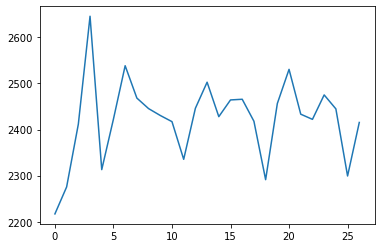

In [9]:
results['avg'] = results.mean(axis=1)
results['avg'].plot()

In [10]:
# results

In [11]:
final = df1[['installs']]
final['type'] = 'Train'
# final = pd.concat([final,test[['installs']]])

final.loc[final['installs'].isna(),'type'] = 'Test'
final.loc[final['installs'].isna(),'installs'] = results['avg'].values

<ipython-input-11-b4513e880734>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['type'] = 'Train'
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


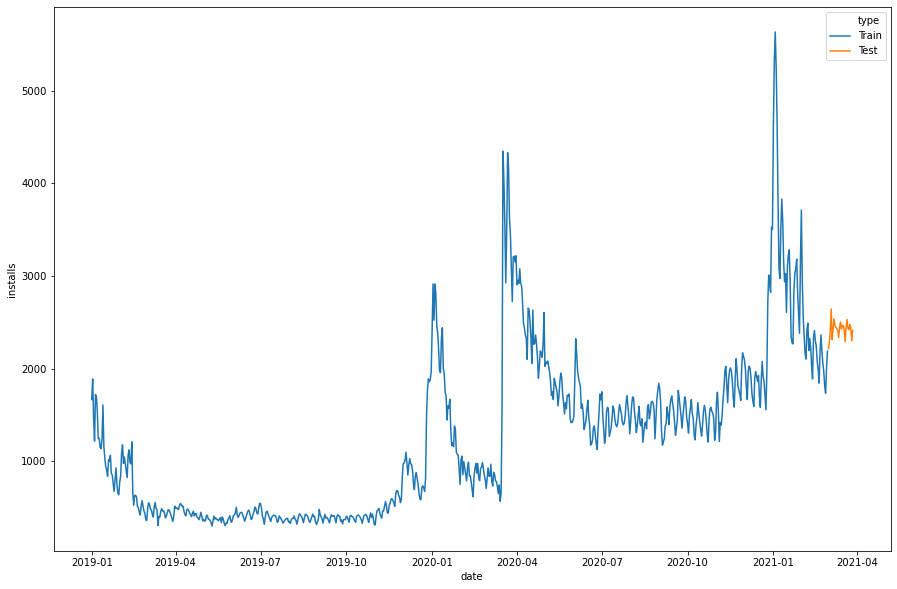

In [12]:
plt.figure(figsize=(15,10))
sns.lineplot(final.index,final['installs'],hue=final['type'])